In [1]:
import os.path as osp

from tqdm import tqdm
import torch
from torch.nn import BCEWithLogitsLoss

import networkx as nx
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_auc_score

from datasets import SEALDataset, SEALDatasetInMemory, toSEAL_pred_datalist
from models import DGCNN
from utils import read_temporary_graph_data, read_graph_from_edgefile

Super parameters:
 - `T`: split number of the time series.
 - `N`: number of predicted continuous time series.
 - `datasets`: the graph datasets, instance of `SEALDataset`.
 - `BS`: batch size.
 - `EPOCH`: number of epochs.
 - `LEARNING_RATE`: learning rate.

In [2]:
T = 100
N = 3
datasets = ['CollegeMsg',]
BS = 8192
EPOCH = 50
LEARN_RATE = 0.0001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def train(model, optimizer, criterion, data_loader, device='cuda'):
    model.train()

    total_loss = 0
    for data in data_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out.view(-1), data.y.to(torch.float))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs

    return total_loss / len(data_loader.dataset)


@torch.no_grad()
def test(model, data_loader, device='cuda'):
    model.eval()

    y_pred, y_true = [], []
    for data in data_loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        y_pred.append(logits.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

    return roc_auc_score(torch.cat(y_true), torch.cat(y_pred))


@torch.no_grad()
def predict(model, data_loader, threshold=0.5, device='cuda'):
    pred_edge_index = torch.zeros(0, 2).to(device)
    model.eval()
    
    for j, data in enumerate(data_loader):
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        logits = logits.view(-1).sigmoid()
        batch_mask = (logits > threshold).nonzero(as_tuple=True)[0]
        pred_edge_index = torch.cat((pred_edge_index, data.pred_edge[batch_mask]), dim=0)
    
    return pred_edge_index.type(torch.int).cpu()


def build_dataloader(dataset_name: str, t: int, additional_graphs=None):
    n = 0 if additional_graphs is None else len(additional_graphs)
    print(f'\nLoading {dataset_name} Dataset with T={t} + {n}...')
    if dataset_name in ['WikiTalk', 'StackOverflow']: # Too big dataset may not process in Memory
        train_dataset = SEALDataset('data/SEALDataset', dataset_name, 'train', pred_idx=-1, num_hops=2, T=t, additional_graphs=additional_graphs)
        val_dataset = SEALDataset('data/SEALDataset', dataset_name, 'val', pred_idx=-1, num_hops=2, T=t, additional_graphs=additional_graphs)
        test_dataset = SEALDataset('data/SEALDataset', dataset_name, 'test', pred_idx=-1, num_hops=2, T=t, additional_graphs=additional_graphs)
    else:
        train_dataset = SEALDatasetInMemory('data/SEALDataset', dataset_name, 'train', num_hops=2, T=t, additional_graphs=additional_graphs)
        val_dataset = SEALDatasetInMemory('data/SEALDataset', dataset_name, 'val', num_hops=2, T=t, additional_graphs=additional_graphs)
        test_dataset = SEALDatasetInMemory('data/SEALDataset', dataset_name, 'test', num_hops=2, T=t, additional_graphs=additional_graphs)
    
    train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BS)
    test_loader = DataLoader(test_dataset, batch_size=BS)
    return train_loader, val_loader, test_loader


def build_model(train_dataset, hidden_channels=32, num_layers=3):
    model = DGCNN(hidden_channels=hidden_channels, num_layers=num_layers, train_dataset=train_dataset).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARN_RATE)
    criterion = BCEWithLogitsLoss()
    return model, optimizer, criterion
    

def load_predict_graph(file_name: str):
    graph = read_graph_from_edgefile(file_name)
    # remove isolate node and self loop
    graph.remove_nodes_from(nx.isolates(graph))
    graph.remove_edges_from(nx.selfloop_edges(graph))
    return graph


for dataset in datasets:
    predict_graphs = []
    t = T
    for n in range(1, N+1):
        # If current graph has been predicted, skip it.
        if osp.exists(f'data/SEALDataset/{dataset}/T{t}+{n}_pred_edge.pt'):
            print(f'{dataset}/T{t}+{n} has been predicted, just load.')
            predict_graphs.append(load_predict_graph(f'data/SEALDataset/{dataset}/T{t}+{n}_pred_edge.pt'))
            continue
        
        train_loader, val_loader, test_loader = build_dataloader(dataset, T, additional_graphs=predict_graphs)
        model, optimizer, criterion = build_model(train_loader.dataset)
        
        if osp.exists(f'data/models/SEAL_{dataset}_T{t}+{n-1}.pth'):
            model.load_state_dict(torch.load(f'data/models/SEAL_{dataset}_T{t}+{n-1}.pth'))
        else:
            print(f'\nTraining {dataset} Dataset with T={t}+{n-1}...')
            best_val_auc = test_auc = 0
            for epoch in tqdm(range(EPOCH)):
                loss = train(model, optimizer, criterion, train_loader)
                val_auc = test(model, val_loader)
                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    test_auc = test(model, test_loader)
                if epoch % 10 == 0 or epoch == EPOCH-1:
                    print(f'Epoch: [{epoch+1:02d}]/[{EPOCH:02d}], Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')
            print(f'Loss: {loss:.4f}, Val_best: {best_val_auc:.4f}, Test: {test_auc:.4f}')
            
            torch.save(model.state_dict(), f'data/models/SEAL_{dataset}_T{T}+{n-1}.pth')
        
        print(f'\nPredicting {dataset} Dataset with T={t} + {n}...')
        test_dataset = test_loader.dataset
        pred_graph = read_temporary_graph_data(test_dataset.graph_data_file_name, test_dataset.raw_file_timespan, t)[-1]
        assert pred_graph.number_of_nodes() > 30
        pred_data_list = toSEAL_pred_datalist(pred_graph, test_dataset.num_features)
        pred_loader = DataLoader(pred_data_list, batch_size=BS)
        pred_edge_index = predict(model, pred_loader, threshold=0.5)
        if pred_edge_index.size(0) == 0:
            # Avoid no edge predicted, we will descend the threshold by 0.01 until we get some edges.
            for threshold in range(50, 0, -1):
                pred_edge_index = predict(model, pred_loader, threshold=threshold/100)
                if pred_edge_index.size(0) > 40:
                    break
        assert pred_edge_index.size(0) > 0, f'No edge predicted in {dataset} Dataset with T={t}...'
        torch.save(pred_edge_index, f'data/SEALDataset/{dataset}/T{t}+{n}_pred_edge.pt')
        # load current pred graph to predict_graphs
        print(f'load {dataset}/T{t}+{n}_pred_edge.pt to dataset')
        predict_graphs.append(load_predict_graph(f'data/SEALDataset/{dataset}/T{t}+{n}_pred_edge.pt'))

        torch.cuda.empty_cache()


Loading CollegeMsg Dataset with T=100 + 0...

Training CollegeMsg Dataset with T=100...


  2%|▏         | 1/50 [00:10<08:36, 10.53s/it]

Epoch: [01]/[50], Loss: 0.6934, Val: 0.6148, Test: 0.6069


 22%|██▏       | 11/50 [00:49<02:35,  3.97s/it]

Epoch: [11]/[50], Loss: 0.6849, Val: 0.6154, Test: 0.6086


 42%|████▏     | 21/50 [01:31<02:01,  4.20s/it]

Epoch: [21]/[50], Loss: 0.6663, Val: 0.6464, Test: 0.6389


 62%|██████▏   | 31/50 [02:12<01:15,  3.99s/it]

Epoch: [31]/[50], Loss: 0.6481, Val: 0.6688, Test: 0.6656


 82%|████████▏ | 41/50 [02:52<00:35,  3.99s/it]

Epoch: [41]/[50], Loss: 0.6393, Val: 0.6942, Test: 0.6894


100%|██████████| 50/50 [03:28<00:00,  4.16s/it]

Epoch: [50]/[50], Loss: 0.6271, Val: 0.7170, Test: 0.7120
Loss: 0.6271, Val_best: 0.7170, Test: 0.7120



Predicting CollegeMsg Dataset with T=100 + 1...
load CollegeMsg/T100+1_pred_edge.pt to dataset

Loading CollegeMsg Dataset with T=100 + 1...


Processing...
Embedding: 100%|██████████| 47/47 [01:34<00:00,  2.02s/it]
Done!



Training CollegeMsg Dataset with T=100...


  2%|▏         | 1/50 [00:04<03:54,  4.78s/it]

Epoch: [01]/[50], Loss: 0.6932, Val: 0.5770, Test: 0.6076


 22%|██▏       | 11/50 [00:43<02:24,  3.71s/it]

Epoch: [11]/[50], Loss: 0.6893, Val: 0.5972, Test: 0.6248


 42%|████▏     | 21/50 [01:22<01:55,  3.99s/it]

Epoch: [21]/[50], Loss: 0.6675, Val: 0.6270, Test: 0.6489


 62%|██████▏   | 31/50 [02:02<01:16,  4.02s/it]

Epoch: [31]/[50], Loss: 0.6511, Val: 0.6584, Test: 0.6763


 82%|████████▏ | 41/50 [02:43<00:37,  4.11s/it]

Epoch: [41]/[50], Loss: 0.6424, Val: 0.6748, Test: 0.6904


100%|██████████| 50/50 [03:20<00:00,  4.00s/it]

Epoch: [50]/[50], Loss: 0.6362, Val: 0.6820, Test: 0.6967
Loss: 0.6362, Val_best: 0.6820, Test: 0.6967

Predicting CollegeMsg Dataset with T=100 + 2...


load CollegeMsg/T100+2_pred_edge.pt to dataset

Loading CollegeMsg Dataset with T=100 + 2...


Processing...
Embedding: 100%|██████████| 47/47 [01:37<00:00,  2.07s/it]
Done!



Training CollegeMsg Dataset with T=100...


  2%|▏         | 1/50 [00:04<03:43,  4.57s/it]

Epoch: [01]/[50], Loss: 0.6930, Val: 0.5899, Test: 0.5891


 22%|██▏       | 11/50 [00:41<02:21,  3.63s/it]

Epoch: [11]/[50], Loss: 0.6895, Val: 0.5972, Test: 0.5973


 42%|████▏     | 21/50 [01:21<01:55,  4.00s/it]

Epoch: [21]/[50], Loss: 0.6766, Val: 0.6272, Test: 0.6266


 62%|██████▏   | 31/50 [02:01<01:15,  3.98s/it]

Epoch: [31]/[50], Loss: 0.6573, Val: 0.6487, Test: 0.6542


 82%|████████▏ | 41/50 [02:41<00:35,  3.99s/it]

Epoch: [41]/[50], Loss: 0.6471, Val: 0.6664, Test: 0.6760


100%|██████████| 50/50 [03:17<00:00,  3.94s/it]

Epoch: [50]/[50], Loss: 0.6399, Val: 0.6926, Test: 0.7079
Loss: 0.6399, Val_best: 0.6954, Test: 0.7079

Predicting CollegeMsg Dataset with T=100 + 3...


load CollegeMsg/T100+3_pred_edge.pt to dataset


In [4]:
predict_graphs

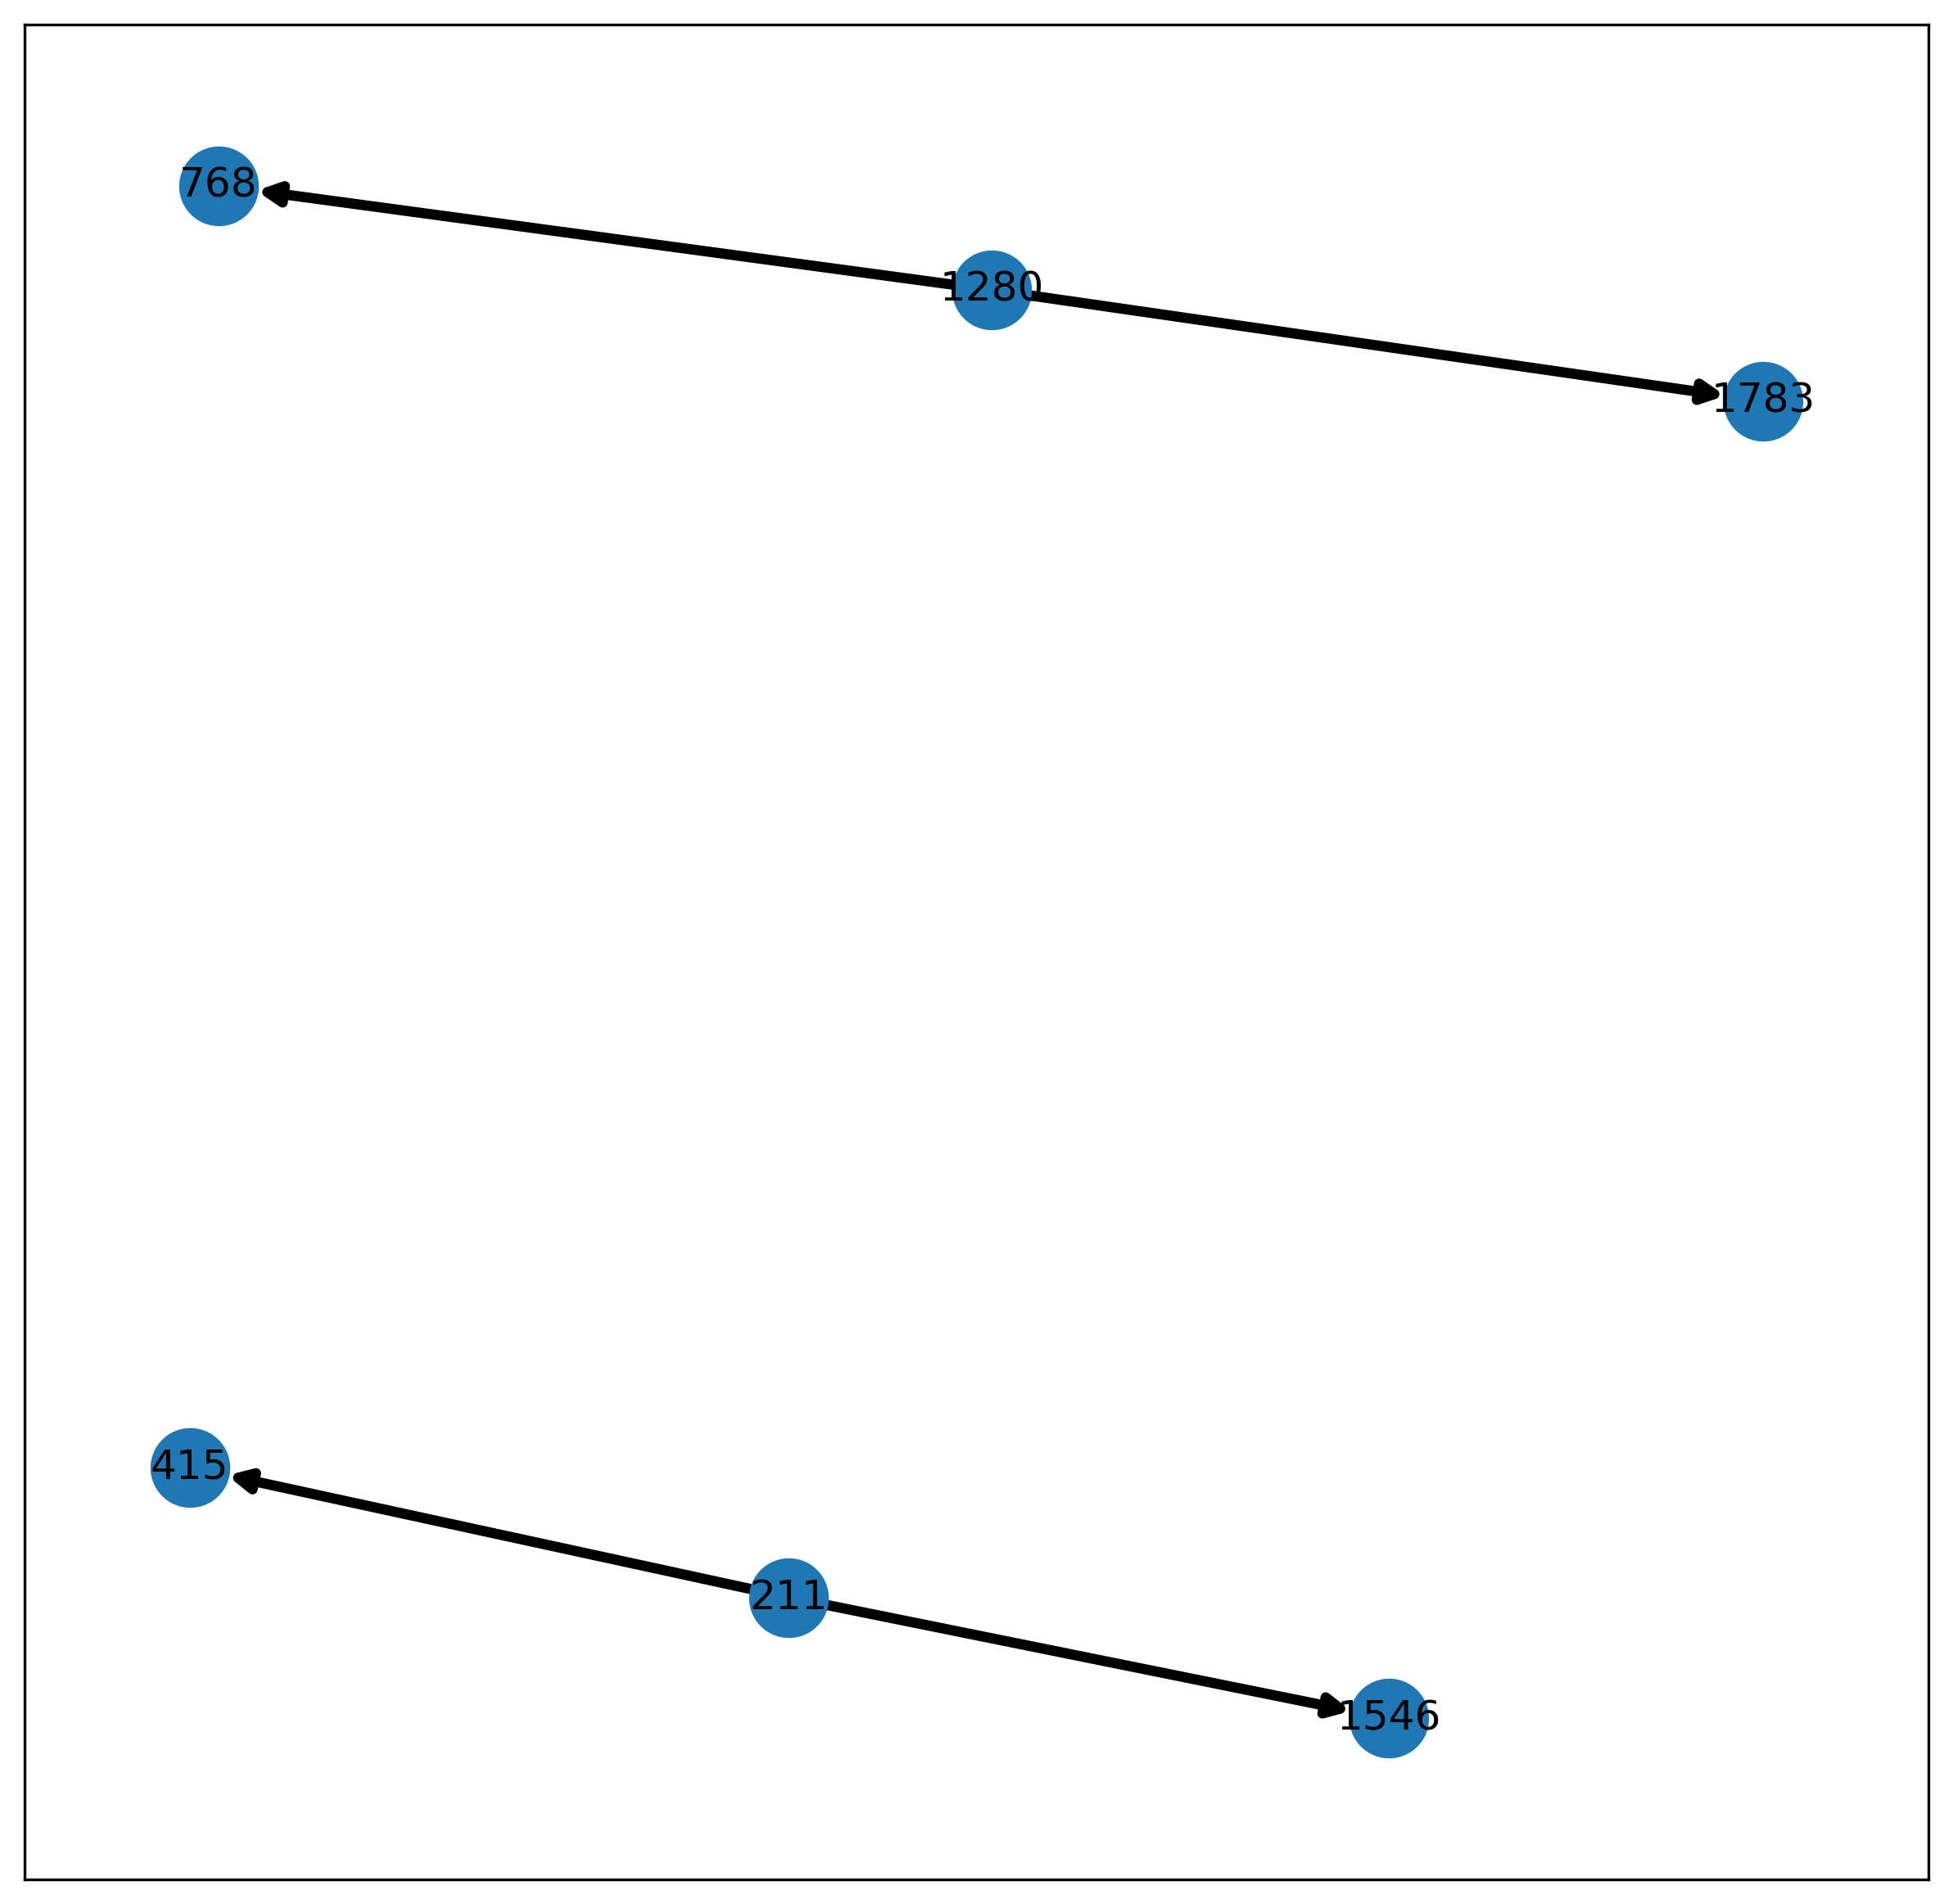

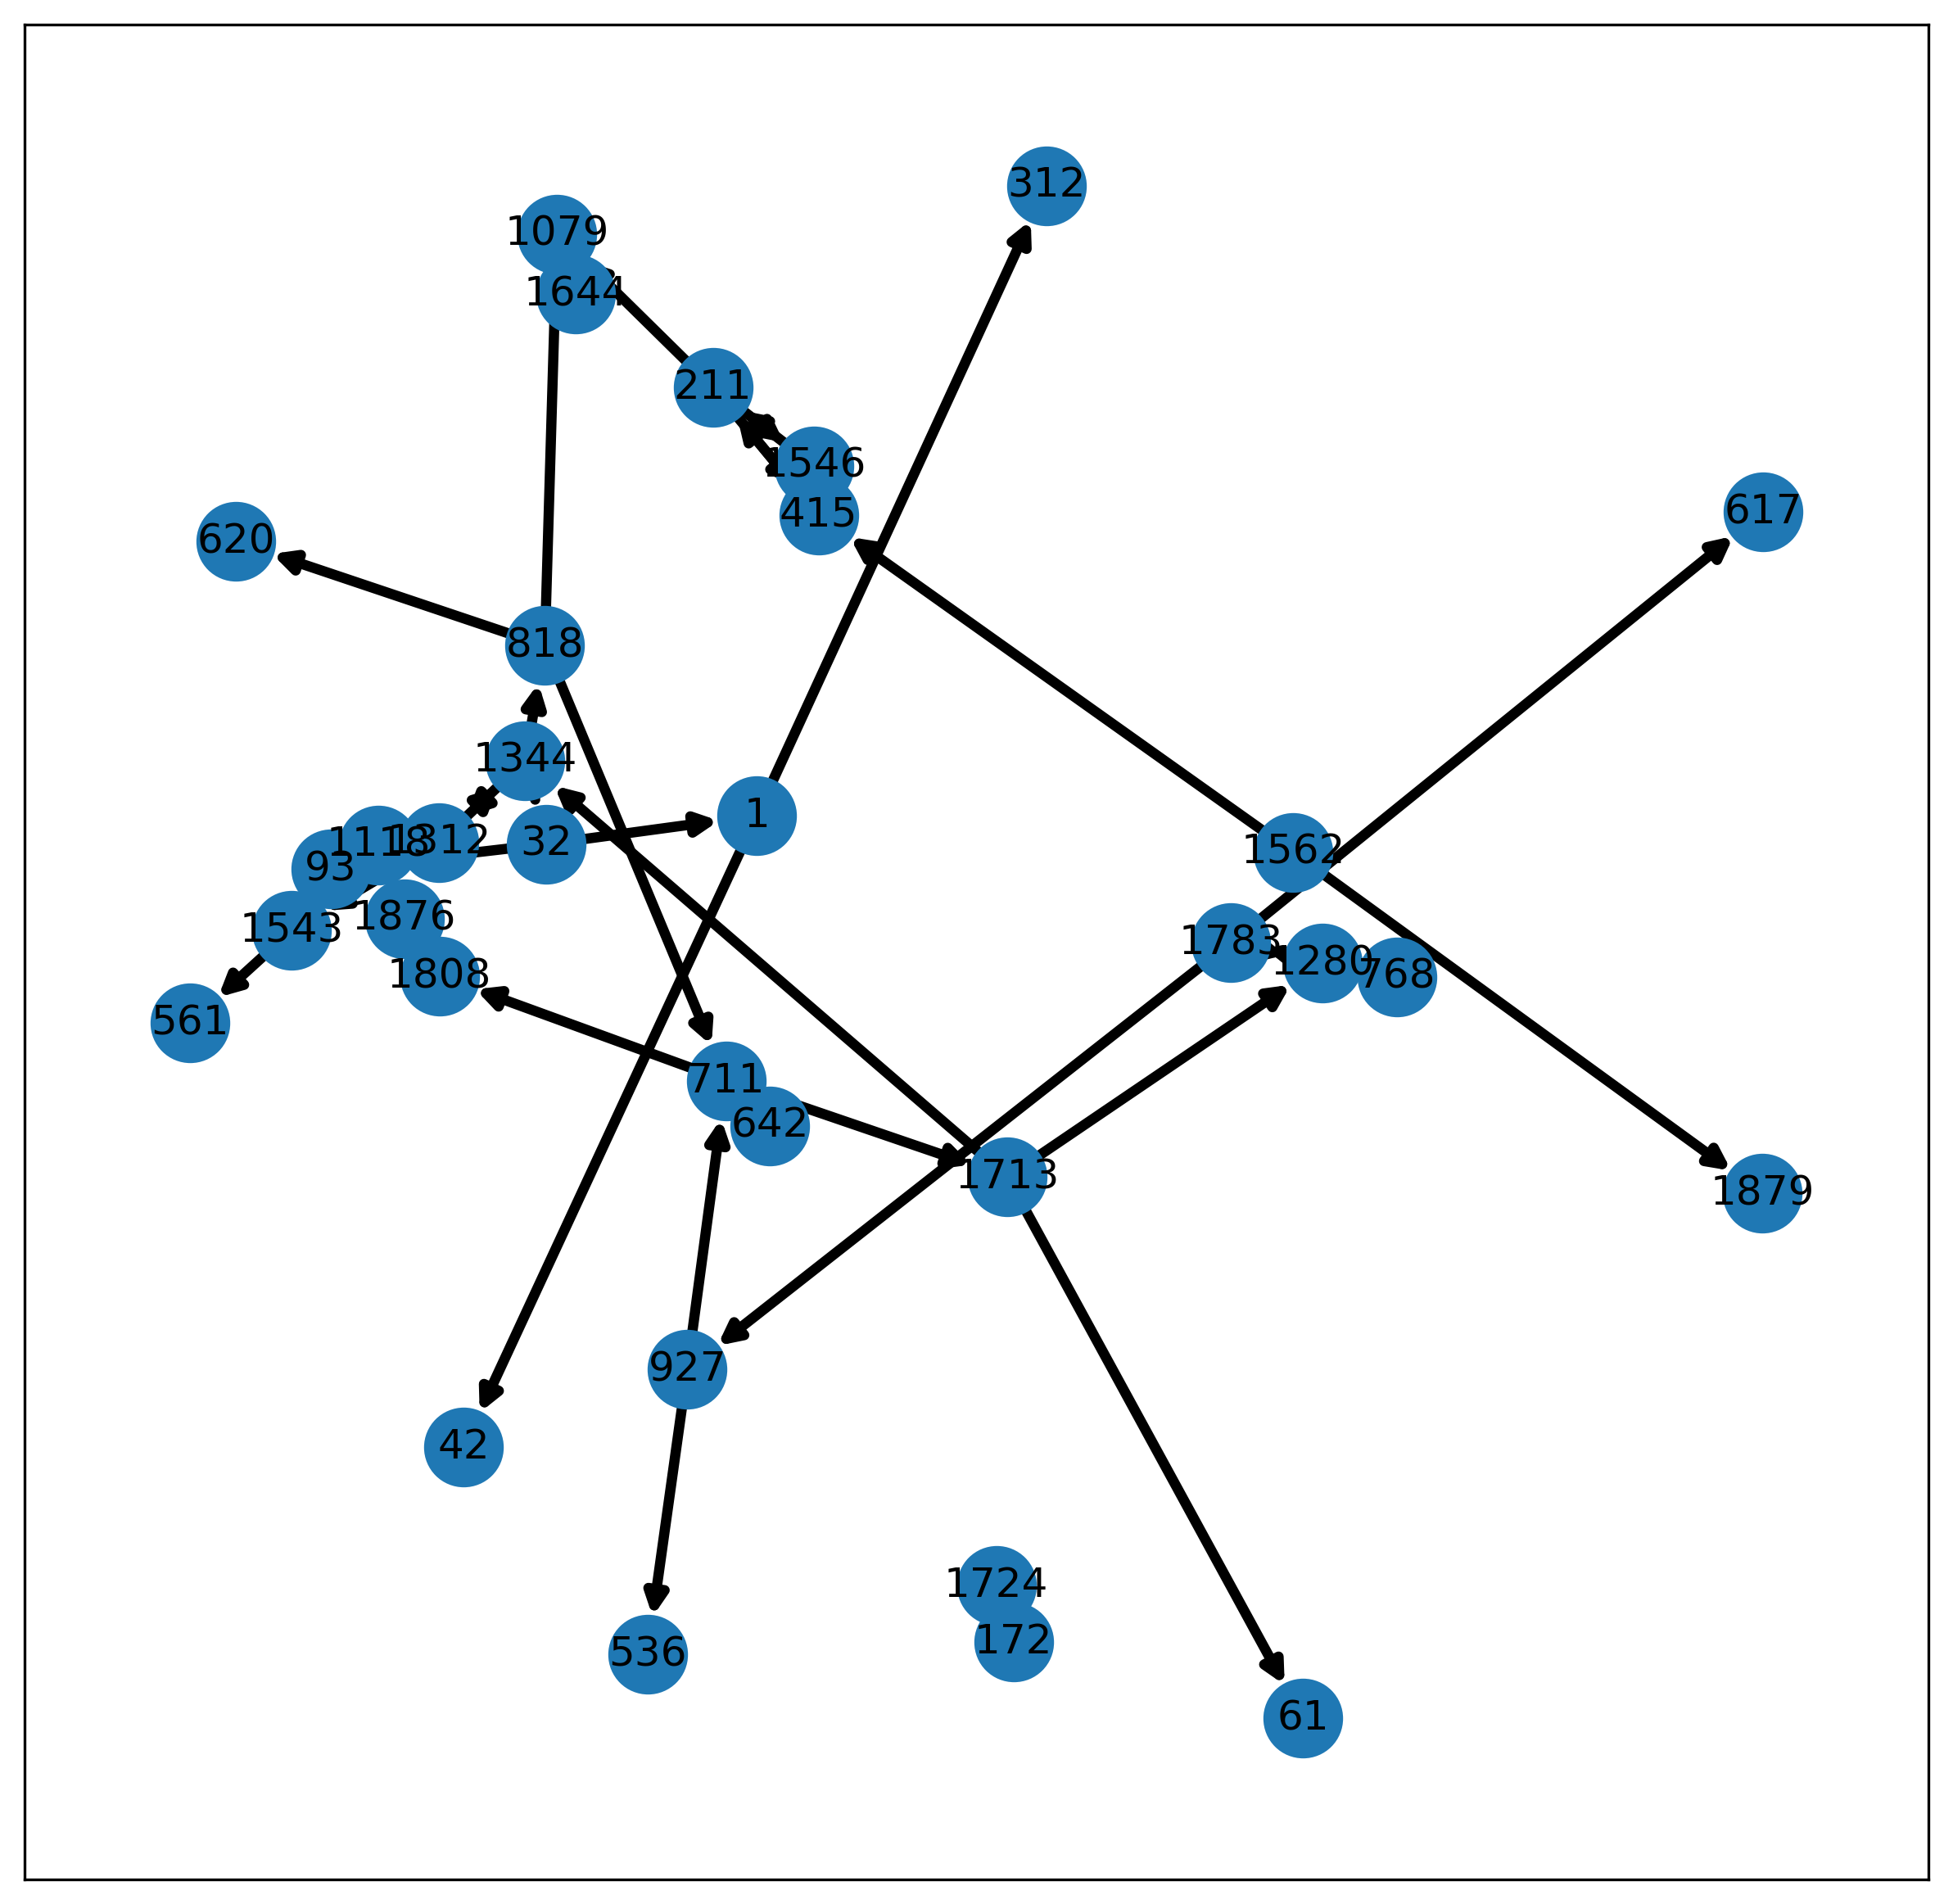

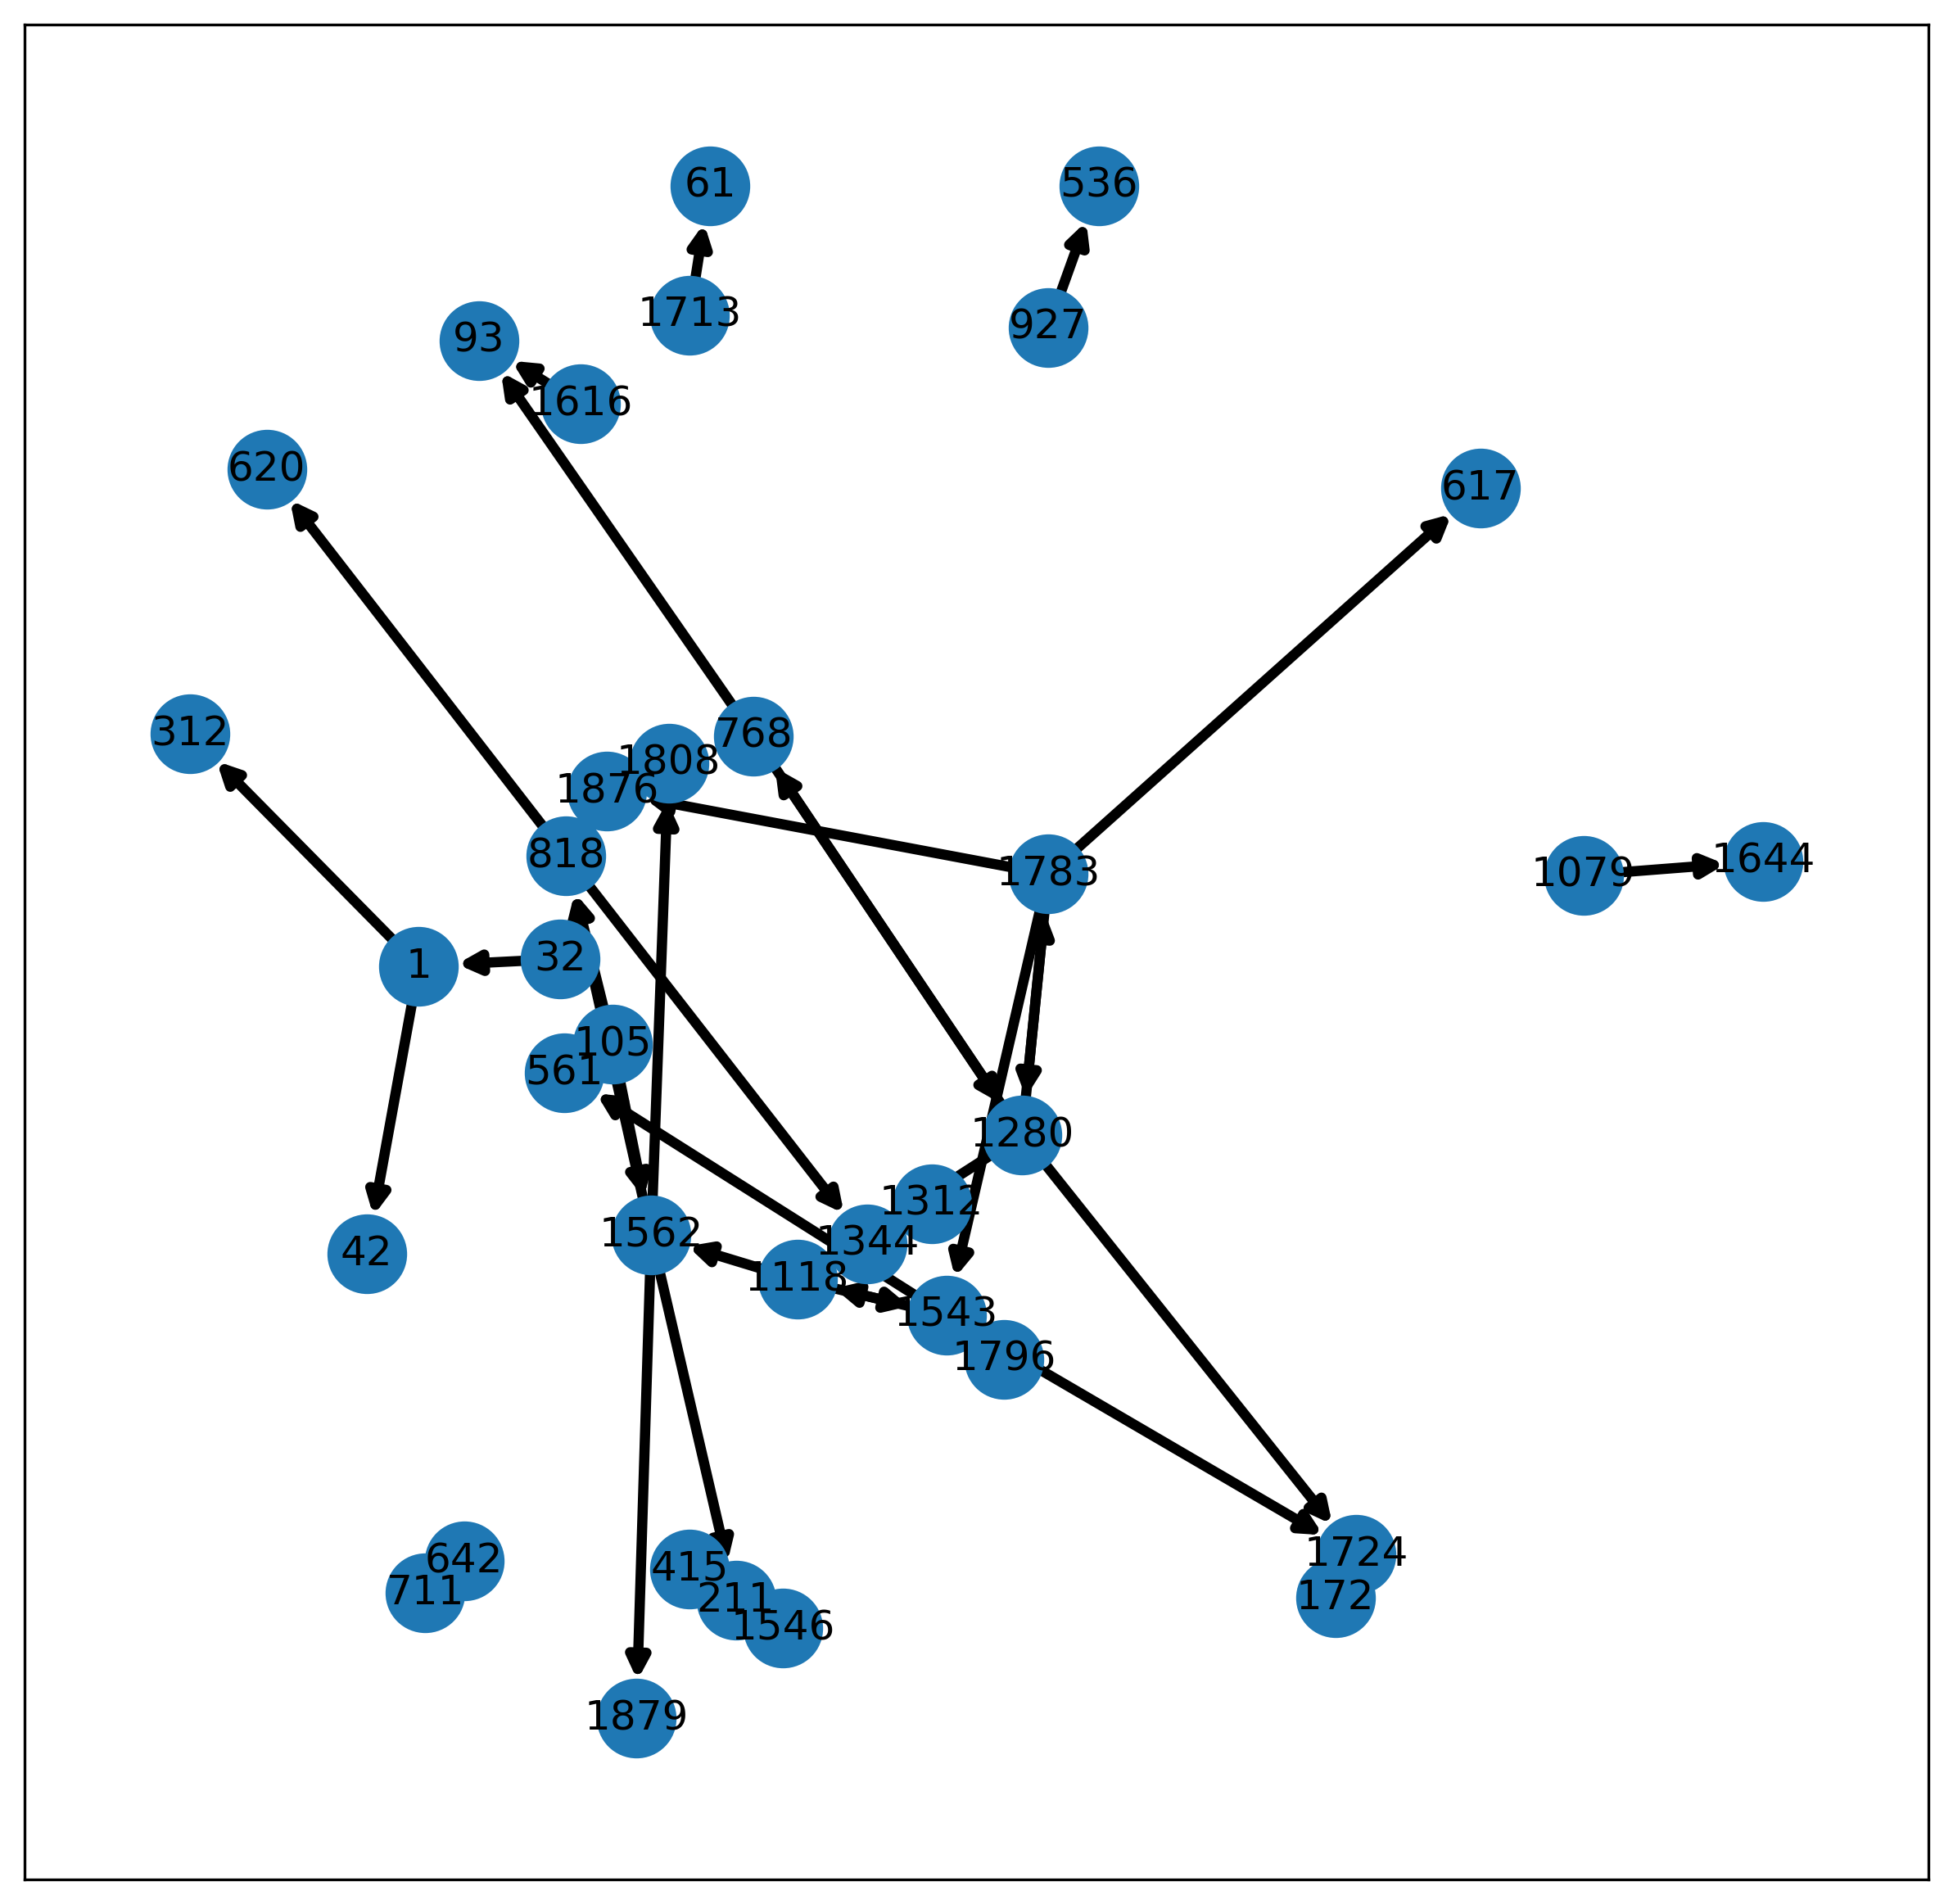

In [5]:
import networkx as nx
from matplotlib import pyplot as plt

for g in predict_graphs:    
    options = {
        'node_color': '#1f78b4',
        'node_size': 500,
        'width': 3,
        'arrowstyle': '-|>',
        'arrowsize': 12,
    }
    ax = plt.figure(figsize=(10, 10), dpi=300)
    nx.draw_networkx(g, pos=nx.spring_layout(g), **options)
    plt.show()